In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
sn.set()

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')

# Creating dataframes that contain PSDs for each insect class

In [3]:
sz = 5000
df_an = make_df_parallel(df_mosquitos, setting='psd', insect_class='Anopheles', sample_size=sz).T
df_an['label'] = 'an'
df_ae = make_df_parallel(df_mosquitos, setting='psd',insect_class='Aedes', sample_size=sz).T
df_ae['label'] = 'ae'
df_cu = make_df_parallel(df_mosquitos, setting='psd',insect_class='Culex', sample_size=sz).T
df_cu['label'] = 'cu'

In [4]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='any', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(labelarray.shape)

(15000, 130)
(15000, 130)
(15000,)


### Example PSD

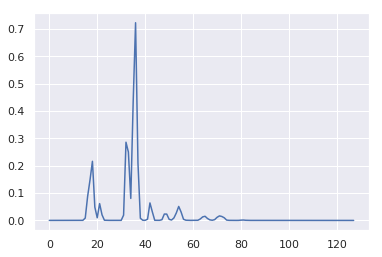

In [5]:
df_concat.iloc[9,:-1].plot()

# Loading the main dataframe created earlier to combine them both into one (merging on index)

In [6]:
df_mosquitos.drop(['names','pathlen','fnamelen','temp','humd','label2'], axis=1, inplace=True)
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')
df_mosquitos.set_index('fname', inplace=True)
print(df_mosquitos.shape)
df_mosquitos.tail(10)

(167725, 16)


,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label1,label2
fname,,,,,,,,,,,,,,,,
F170301_193157_020_G_050_T_25.9_H_56.0,0.032887,0.093844,0.001396,810.546875,1625.000000,2425.781250,0.040964,0.009014,0.010870,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193314_029_G_050_T_25.9_H_56.0,0.122471,0.086202,0.002711,764.648438,1562.500000,2289.062500,0.031290,0.022187,0.009812,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193417_033_G_050_T_25.9_H_56.0,0.127117,0.042620,0.000739,787.109375,1582.031250,2305.664062,0.031638,0.010802,0.007412,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193421_034_G_050_T_25.9_H_56.0,0.038245,0.012146,0.000624,728.515625,1417.968750,2151.367188,0.038204,0.025826,0.006809,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193636_042_G_050_T_25.9_H_56.5,0.111496,0.092593,0.001553,544.921875,1102.539062,1555.664062,0.049283,0.011957,0.010986,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.5,Aedes,Ae. albopictus
F170301_193915_054_G_050_T_25.9_H_56.0,0.066598,0.136234,0.004561,527.343750,1052.734375,1562.500000,0.047222,0.027829,0.023750,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193916_055_G_050_T_25.9_H_56.0,0.113899,0.092764,0.032408,518.554688,1027.343750,1505.859375,0.048023,0.026141,0.020752,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_194005_064_G_050_T_25.9_H_56.0,0.082995,0.010639,0.001265,811.523438,1614.257812,2411.132812,0.044525,0.016939,0.012961,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_194043_070_G_050_T_25.9_H_56.5,0.096156,0.014383,0.001267,832.031250,1676.757812,2431.640625,0.036972,0.011066,0.007430,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.5,Aedes,Ae. albopictus


In [7]:
df = pd.merge(df_mosquitos, df_concat, left_index=True, right_index=True)
df.drop(['label1','label2','names','pathlen','fnamelen','humd','temp'], axis=1, inplace=True)
df.to_pickle('./data/big_df.pkl')

In [8]:
#df.read_pickle('./data/big_df.pkl')
df.head()

,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,0,...,119,120,121,122,123,124,125,126,127,128
F161205_162347_045_G_050,0.052670,0.165347,0.011363,684.570312,1370.117188,2056.640625,0.032097,0.016037,0.010921,0.000052,...,2.901378e-07,2.854040e-07,2.850186e-07,2.826532e-07,2.811257e-07,2.798741e-07,2.788877e-07,2.782103e-07,2.778028e-07,1.388328e-07
F161205_162714_054_G_050,0.082675,0.012629,0.005209,654.296875,1298.828125,1957.031250,0.035075,0.018797,0.014721,0.000115,...,8.520049e-07,8.522498e-07,8.473297e-07,8.453288e-07,8.425719e-07,8.403101e-07,8.389474e-07,8.377557e-07,8.370989e-07,4.184392e-07
F161205_164632_107_G_050,0.138870,0.102028,0.002742,654.296875,1312.500000,1972.656250,0.032836,0.016369,0.011386,0.000025,...,2.276810e-07,2.268583e-07,2.255593e-07,2.246418e-07,2.239952e-07,2.233189e-07,2.228138e-07,2.224805e-07,2.222659e-07,1.110984e-07
F161205_165039_124_G_050,0.108405,0.131251,0.009256,600.585938,1200.195312,1804.687500,0.035772,0.019935,0.014881,0.000077,...,6.473465e-07,6.454969e-07,6.421749e-07,6.405290e-07,6.382482e-07,6.367977e-07,6.355925e-07,6.347593e-07,6.342474e-07,3.170389e-07
F161205_165330_134_G_050,0.044811,0.143673,0.015545,693.359375,1391.601562,2090.820312,0.033099,0.015789,0.011677,0.000096,...,8.944473e-07,8.892885e-07,8.856698e-07,8.816727e-07,8.788135e-07,8.767022e-07,8.747528e-07,8.734291e-07,8.726520e-07,4.361946e-07


## Classes' value counts

In [9]:
df = df_concat
cols = df.columns.tolist()
labels = labelarray
classes = np.unique(labelarray)
#df.label.value_counts()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
F170211_205847_254_G_050,0.000340,0.000312,0.000112,0.000285,0.000292,0.000230,0.000269,0.000177,0.000177,0.000166,...,7.153504e-07,7.119514e-07,7.107907e-07,7.085388e-07,7.073696e-07,7.058442e-07,7.049428e-07,7.042618e-07,7.038428e-07,3.518526e-07
F170208_201423_031_G_050,0.000086,0.000073,0.000104,0.000172,0.000114,0.000095,0.000069,0.000046,0.000038,0.000046,...,7.857599e-07,7.773025e-07,7.724766e-07,7.673597e-07,7.641317e-07,7.609121e-07,7.586442e-07,7.569451e-07,7.559544e-07,3.778120e-07
F170207_132135_237_G_050,0.000114,0.000110,0.000184,0.000979,0.001025,0.000946,0.000824,0.000714,0.000610,0.000533,...,1.213243e-06,1.203787e-06,1.199896e-06,1.195276e-06,1.191767e-06,1.188406e-06,1.185981e-06,1.184354e-06,1.183307e-06,5.914827e-07
F170213_045223_231_G_050,0.000369,0.000330,0.000087,0.000365,0.000718,0.000743,0.000545,0.000570,0.000763,0.000625,...,5.668542e-07,5.634172e-07,5.620694e-07,5.612093e-07,5.598595e-07,5.591745e-07,5.585091e-07,5.580108e-07,5.577311e-07,2.788190e-07
F170211_105937_015_G_050,0.000135,0.000267,0.001408,0.006074,0.004759,0.003319,0.003345,0.003059,0.003245,0.003743,...,8.660888e-07,8.612949e-07,8.555924e-07,8.515065e-07,8.496129e-07,8.472910e-07,8.449541e-07,8.435565e-07,8.427495e-07,4.212399e-07


# Training a classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(df, labelarray, random_state=3)
#del df

"""
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=100, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

Name: XGBoost, ac: 0.763000


## Feature importance

In [11]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                    index = df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
12,0.034766
14,0.034283
2,0.029454
3,0.025592
30,0.020763
20,0.020763
41,0.020280
13,0.019797
23,0.018831
25,0.017866


# Confusion matrix

In [12]:
cm = confusion_matrix(y_test, y_pred)
len(labels)

15000

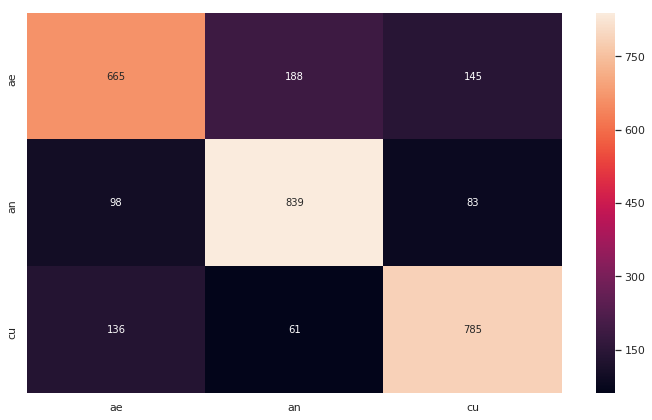

In [13]:
# Making a dataframe of the confusion matrix to plot it
df_cm = pd.DataFrame(cm, index=[i for i in classes], 
                    columns=[i for i in classes])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True, fmt='g')

plt.show()

In [14]:
sub = np.concatenate((X, y.reshape(-1,1)), axis=1)
sub = pd.DataFrame(sub)
sub.sort_values(by=sub.iloc[:,-1].name, inplace=True)

In [15]:
sub.dropna(how='any', axis=0, inplace=True)


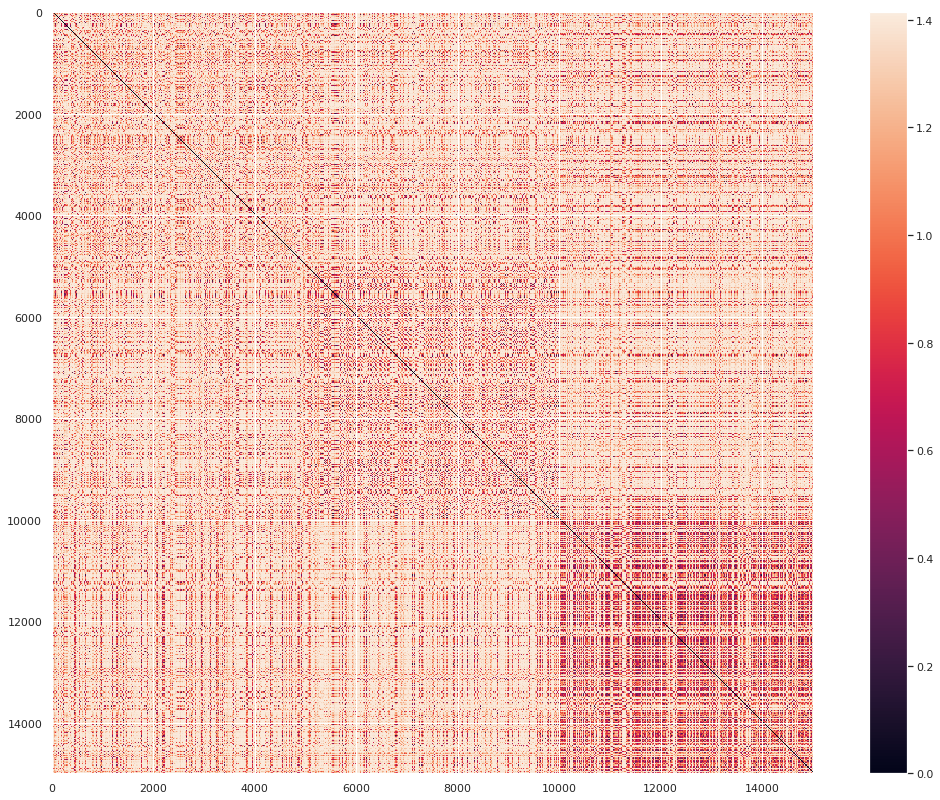

In [16]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(sub.values[:,:-1], metric='euclidean'))
#‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, 
#‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
#‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

plt.figure(figsize=(20,14))
plt.imshow(D)
plt.colorbar()

In [17]:
def find_median_signal(D=None):
    a = np.nanmedian(D, axis=0)
    minval = np.argmin(a[np.nonzero(a)])
    return minval # index - argmin

In [18]:
X = sub.values[:,:-1]

In [19]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

xx = X[100,:]
yy = X[13,:]

distance, path = fastdtw(xx, yy, dist=euclidean)
print(distance)

xx_idx = np.array([path[i][0] for i in range(len(path))])
yy_idx = np.array([path[i][1] for i in range(len(path))])

1.257789086933024


(0, 4000)

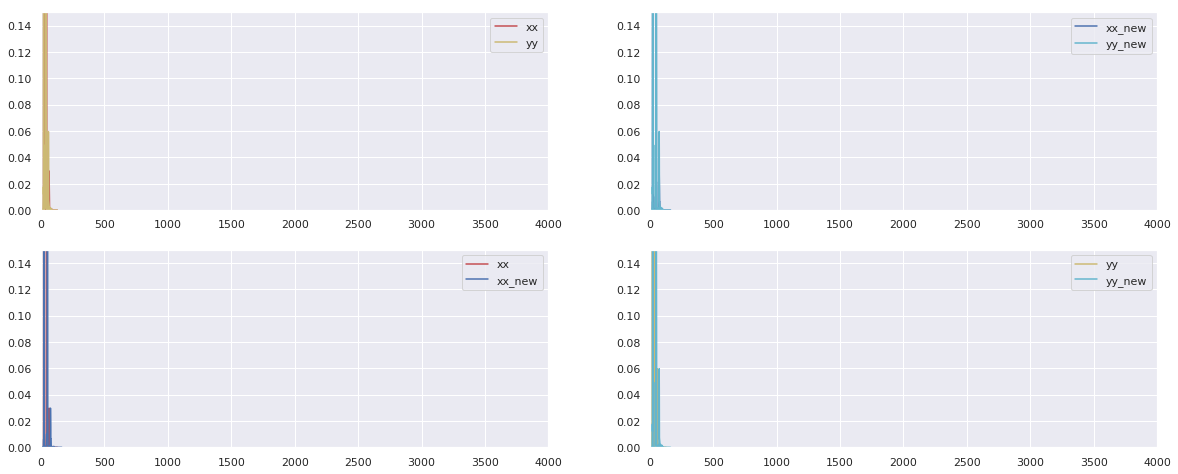

In [20]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(xx, c='r')
plt.plot(yy, c='y')
plt.legend(('xx','yy'))
plt.ylim(0,0.15)
plt.xlim(0,4000)


plt.subplot(2,2,2)
plt.plot(xx[xx_idx], c='b')
plt.plot(yy[yy_idx], c='c')
plt.legend(('xx_new','yy_new'))
plt.ylim(0,0.15)
plt.xlim(0,4000)


plt.subplot(2,2,3)
plt.plot(xx, c='r')
plt.plot(xx[xx_idx], c='b')
plt.legend(('xx','xx_new'))
plt.ylim(0,0.15)
plt.xlim(0,4000)

plt.subplot(2,2,4)
plt.plot(yy, c='y')
plt.plot(yy[yy_idx], c='c')
plt.legend(('yy','yy_new'))
plt.ylim(0,0.15)
plt.xlim(0,4000)


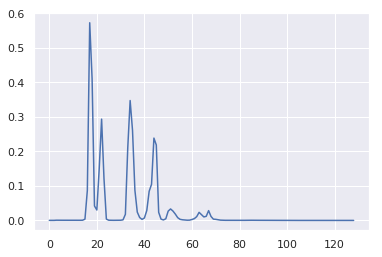

In [21]:
median_signal_idx = find_median_signal(D=X.astype(float))
median_signal = X[median_signal_idx,:]
plt.plot(median_signal)

In [22]:
#X.shape

D_dtw = np.zeros((600,600))

def warp_with_median_signal(xx, median_signal, distance=euclidean):
    _, path = fastdtw(xx, median_signal, dist=distance)
    
    idx = np.array([path[i][0] for i in range(len(path))])
    sig = xx[idx]
    
    return sig[:2500]

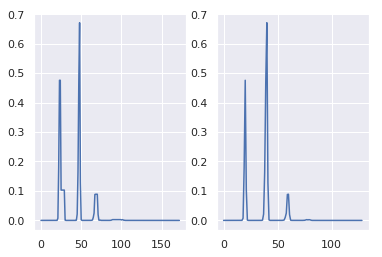

In [23]:
sig = X[10,:]
plt.subplot(1,2,1)
plt.plot(warp_with_median_signal(sig, median_signal, distance=euclidean))
#plt.xlim(0,2500)

plt.subplot(1,2,2)
plt.plot(sig)
#plt.xlim(0,2500)

In [24]:
from tqdm import tqdm

XX = []
for i in tqdm(range(X.shape[0])):
    XX.append(warp_with_median_signal(X[i,:], median_signal, distance=euclidean))

 20%|██        | 3035/15000 [01:36<06:20, 31.46it/s]

KeyboardInterrupt: 

In [ ]:
XX = np.vstack(XX)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(XX, y, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=300, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm